# Imports

In [7]:
from warnings import filterwarnings
filterwarnings('ignore')

In [96]:
import os
import glob as gb
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import classification_report, confusion_matrix

# Reading Images

In [9]:
img_dim = 128

MOD_classes = ['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT']

path = "/kaggle/input/teeth-dataset1/Teeth_Dataset/"

In [10]:
# Reading Images and Labeling them
def read_image_from_path(path, img_dim, gray_scale=False):
    X = []
    y = []

    for folder in os.listdir(path):
        files = gb.glob(pathname = str(path + '/' + folder + '/*jpg'))
        for file in files:
          image = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
          image_array = cv2.resize(image, (img_dim, img_dim))
          X.append(image_array)
          y.append(MOD_classes.index(folder))
            
    return np.array(X), np.array(y)

In [11]:
X_train, y_train = read_image_from_path(path + 'Training', img_dim, True)
X_test, y_test = read_image_from_path(path + 'Testing', img_dim, True)
X_validate, y_validate = read_image_from_path( path +'Validation', img_dim, True)

In [12]:
X_train.shape, X_test.shape, X_validate.shape

((3087, 128, 128), (1028, 128, 128), (1028, 128, 128))

In [13]:
y_train.shape, y_test.shape, y_validate.shape

((3087,), (1028,), (1028,))

# Exploring Data

In [14]:
def visualize_count(y, name):    
  # Count each emotion and turn it into dataframe
  disease_df = pd.DataFrame([MOD_classes[i] for i in y], columns=['Disease'])
  disease_order = disease_df['Disease'].value_counts().sort_values(ascending=False).index

  sns.set_style(style='whitegrid')

  plt.figure(figsize=(12, 6))
    
  sns.countplot(data = disease_df, x='Disease', palette='icefire', order=disease_order)
  plt.xlabel('Disease', color = 'black', fontsize=12)
  plt.ylabel('Frequency', color = 'black', fontsize=12)
  plt.title(f'{name} Images Distribution', color = 'black', fontweight='medium', fontsize=15)
  plt.xticks(color = 'black')
  plt.yticks(color = 'black')
  plt.show()

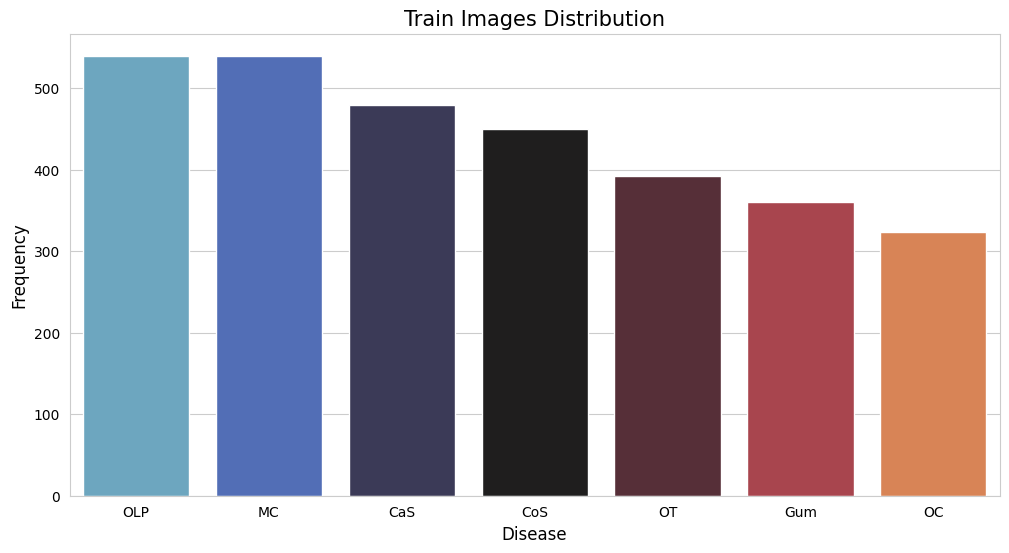

In [15]:
visualize_count(y_train, 'Train')

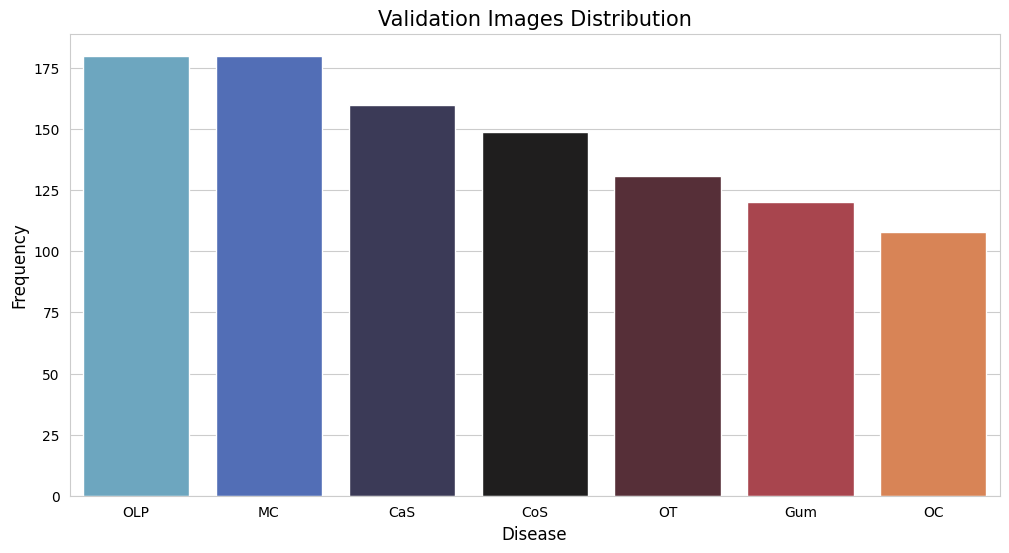

In [16]:
visualize_count(y_validate, 'Validation')

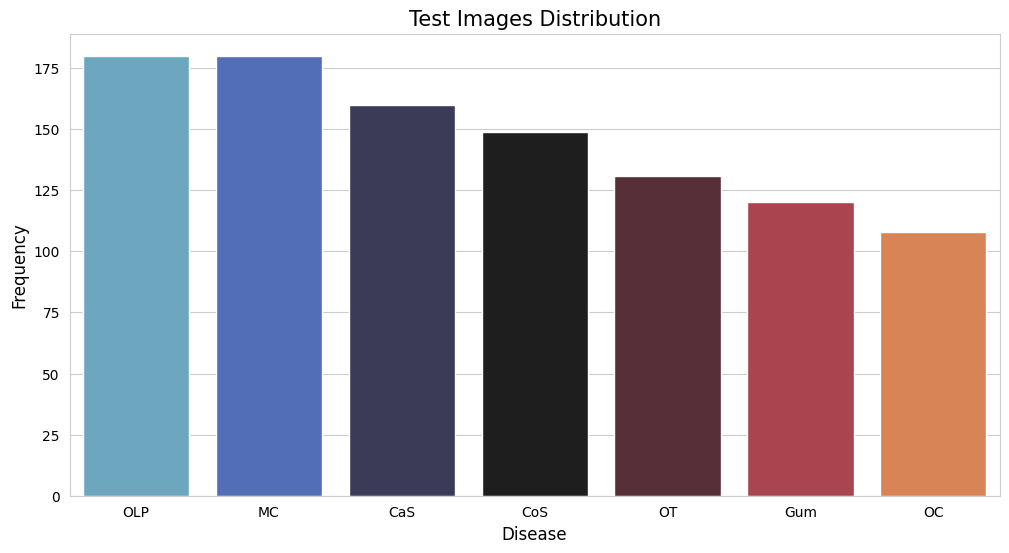

In [17]:
visualize_count(y_test, 'Test')

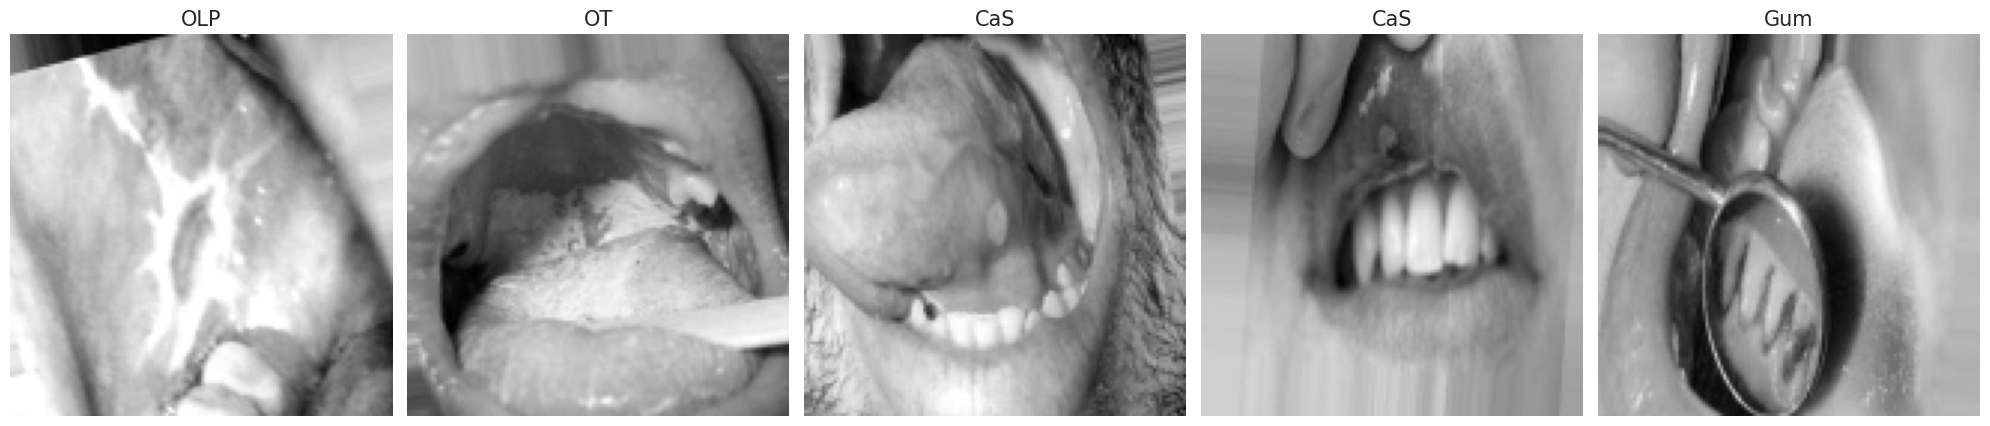

In [18]:
plt.figure(figsize=(20, 10))

for i in range(10):
  img_no = np.random.randint(0, X_train.shape[0])
  plt.subplot(2, 5, i + 1)
  plt.imshow(X_train[img_no], cmap='gray')
  plt.axis('off')
  plt.title(MOD_classes[y_train[img_no]], fontsize = 15, fontweight='medium')
  plt.tight_layout()
  plt.grid(False)
plt.show()

# Data preprocessing

## Normalization

In [19]:
X_train = X_train / 255
X_validate = X_validate / 255
X_test = X_test / 255

In [20]:
X_train = X_train.reshape(-1, img_dim, img_dim, 1)
X_validate = X_validate.reshape(-1, img_dim, img_dim, 1)
X_test = X_test.reshape(-1, img_dim, img_dim, 1)

## Data Augmentation

In [21]:
train_datagen = ImageDataGenerator(
    width_shift_range=0.1,     # Slight horizontal shifts
    height_shift_range=0.1,    # Slight vertical shifts
    horizontal_flip=True,      # Faces can appear mirrored
)

# Create data generators
train_generator = train_datagen.flow(X_train, y_train, batch_size=64)

## Visualizing Augmented Samples

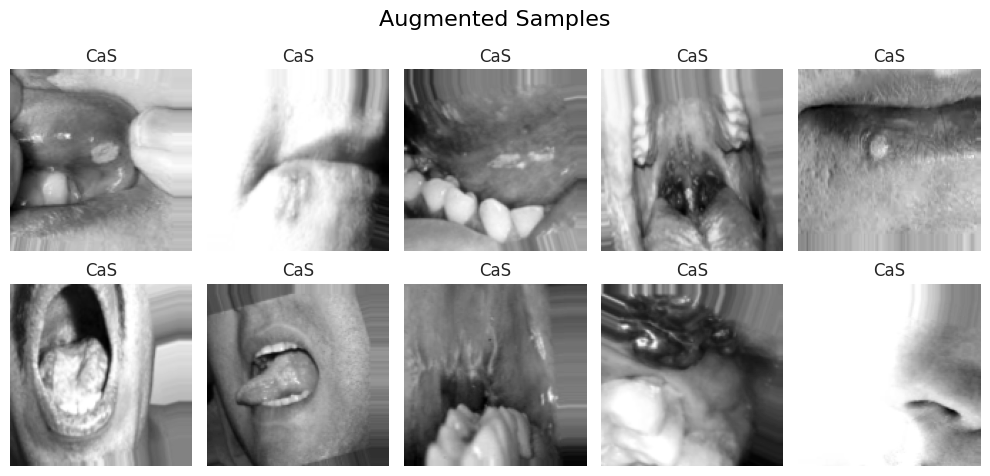

In [22]:
images, labels = next(train_generator)

plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i], cmap='gray')
    plt.title(MOD_classes[np.argmax(labels[i])])
    plt.axis('off')
plt.suptitle('Augmented Samples', fontsize=16, color='black')
plt.tight_layout()
plt.show()

# Model(custom)

In [56]:
model = Sequential()

# CNN First Layer
model.add(Conv2D(32,(3,3), padding='same', activation = 'relu', input_shape = (img_dim, img_dim, 1)))
model.add(Dropout(0.3))

# CNN Second Layer
model.add(Conv2D(64, (3,3), padding='same', activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

# CNN Third Layer
model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

# CNN Fourth Layer
model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

#Flatten Layer
model.add(Flatten())

# Dense First Layer
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

# Dense Second Layer
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# Output Layer
model.add(Dense(7, activation='softmax'))

model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_42 (Conv2D)                   │ (None, 128, 128, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_28 (Dropout)                 │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_43 (Conv2D)                   │ (None, 128, 128, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_28 (MaxPooling2D)      │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_29 (Dropout)                 │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_44 (Conv2D)                   │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_29 (MaxPooling2D)      │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_30 (Dropout)                 │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_45 (Conv2D)                   │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_30 (MaxPooling2D)      │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_31 (Dropout)                 │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_12 (Flatten)                 │ (None, 65536)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 256)                 │      16,777,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_32 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_33 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,199,111 (65.61 MB)

 Trainable params: 17,199,111 (65.61 MB)

 Non-trainable params: 0 (0.00 B)

In [57]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stoping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Training

In [82]:
history = model.fit(train_generator,
                    epochs = 50,
                    validation_data = (X_validate, y_validate),
                    callbacks = [early_stoping])

Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - accuracy: 0.8608 - loss: 0.4222 - val_accuracy: 0.9193 - val_loss: 0.2766
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - accuracy: 0.8513 - loss: 0.4154 - val_accuracy: 0.8930 - val_loss: 0.3462
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - accuracy: 0.8352 - loss: 0.4929 - val_accuracy: 0.8920 - val_loss: 0.3398
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - accuracy: 0.8450 - loss: 0.4490 - val_accuracy: 0.9018 - val_loss: 0.3089
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - accuracy: 0.8507 - loss: 0.4429 - val_accuracy: 0.9027 - val_loss: 0.3092
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - accuracy: 0.8453 - loss: 0.4662 - val_accuracy: 0.9008 - val_loss: 0.3104
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - accuracy: 0.8732 - loss: 0.3923 - val_accuracy: 0.9270 - val_loss: 0.2582
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - accuracy: 0.8369 - loss: 0.4476 - val_accuracy: 0.8872 - v

# Evaluating

In [83]:
model_eval = model.evaluate(X_test, y_test)
print("Loss of Model: ", model_eval[0])
print("Accuracy of Model:", round(model_eval[1]*100,2),'%')

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9390 - loss: 0.1959
Loss of Model:  0.1830865740776062
Accuracy of Model: 94.36 %


In [84]:
model_eval = model.evaluate(X_validate, y_validate)
print("Loss of Model: ", model_eval[0])
print("Accuracy of Model:", round(model_eval[1]*100,2),'%')

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9395 - loss: 0.2073
Loss of Model:  0.19830022752285004
Accuracy of Model: 93.77 %


In [85]:
model_eval = model.evaluate(X_train, y_train)
print("Loss of Model: ", model_eval[0])
print("Accuracy of Model:", round(model_eval[1]*100,2),'%')

97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9988 - loss: 0.0251
Loss of Model:  0.026356853544712067
Accuracy of Model: 99.74 %


# Loss & Accuracy Graph

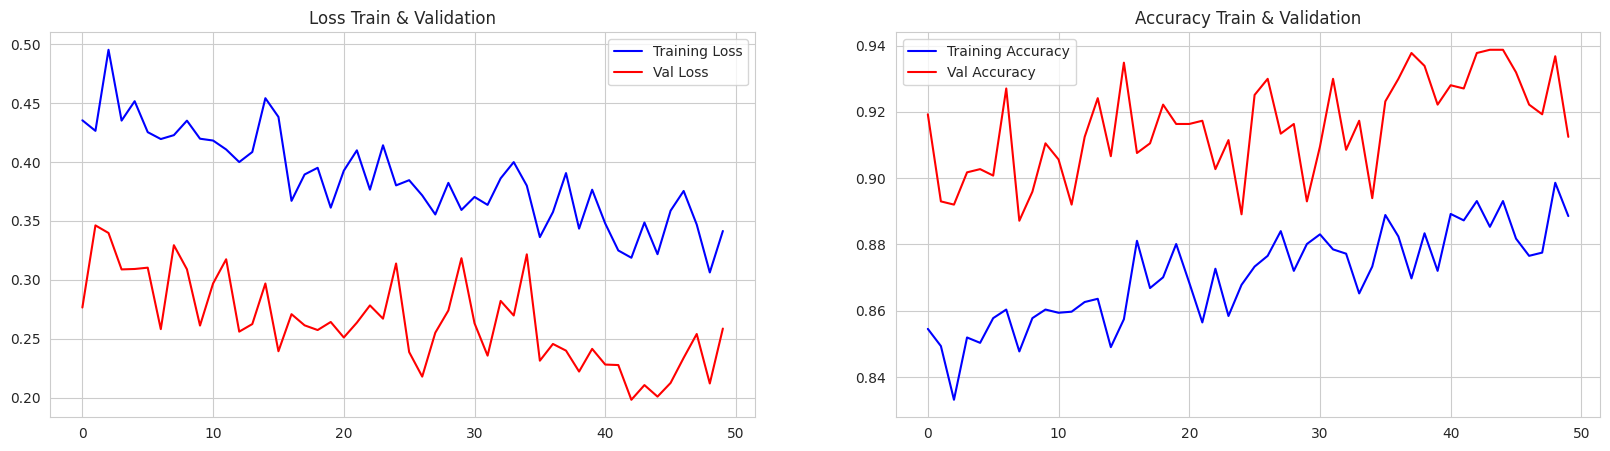

In [86]:
plt.figure(figsize = (20,5))

plt.subplot(1,2,1)
sns.lineplot(x=history.epoch, y=history.history['loss'], color='blue', label='Training Loss')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], color='red', label='Val Loss')
plt.title('Loss Train & Validation')
plt.legend(loc='best')

plt.subplot(1,2,2)
sns.lineplot(x=history.epoch, y=history.history['accuracy'], color='blue', label='Training Accuracy')
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], color='red', label='Val Accuracy')
plt.title('Accuracy Train & Validation')
plt.legend(loc='best')

plt.show()

# Classification Report


In [87]:
predicitions = model.predict(X_test)

# y_test_int = np.argmax(y_test, axis=1)
predicitions = np.argmax(predicitions, axis=1)

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


In [88]:
print(classification_report(y_test, predicitions, target_names=MOD_classes))

              precision    recall  f1-score   support

         CaS       0.97      0.96      0.97       160
         CoS       0.97      0.97      0.97       149
         Gum       0.97      0.94      0.96       120
          MC       0.98      0.92      0.95       180
          OC       0.85      0.91      0.88       108
         OLP       0.91      0.93      0.92       180
          OT       0.93      0.97      0.95       131

    accuracy                           0.94      1028
   macro avg       0.94      0.94      0.94      1028
weighted avg       0.95      0.94      0.94      1028



# Confusion matrix

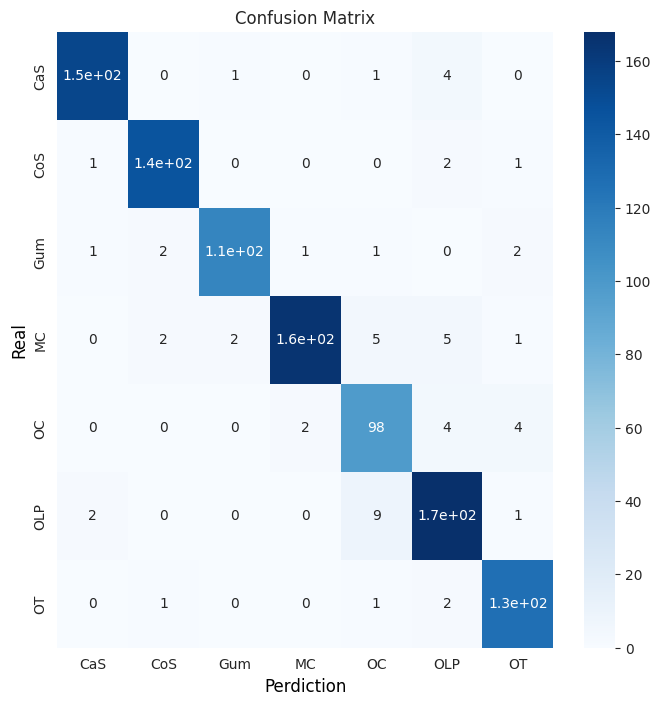

In [91]:
cm = confusion_matrix(y_test, predicitions)
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, xticklabels= MOD_classes, yticklabels=MOD_classes, cmap='Blues')
plt.xlabel('Perdiction',fontsize = 12, color='black')
plt.ylabel('Real', fontsize = 12, color='black')
plt.title('Confusion Matrix')
plt.show()

# Prediction Vs Real

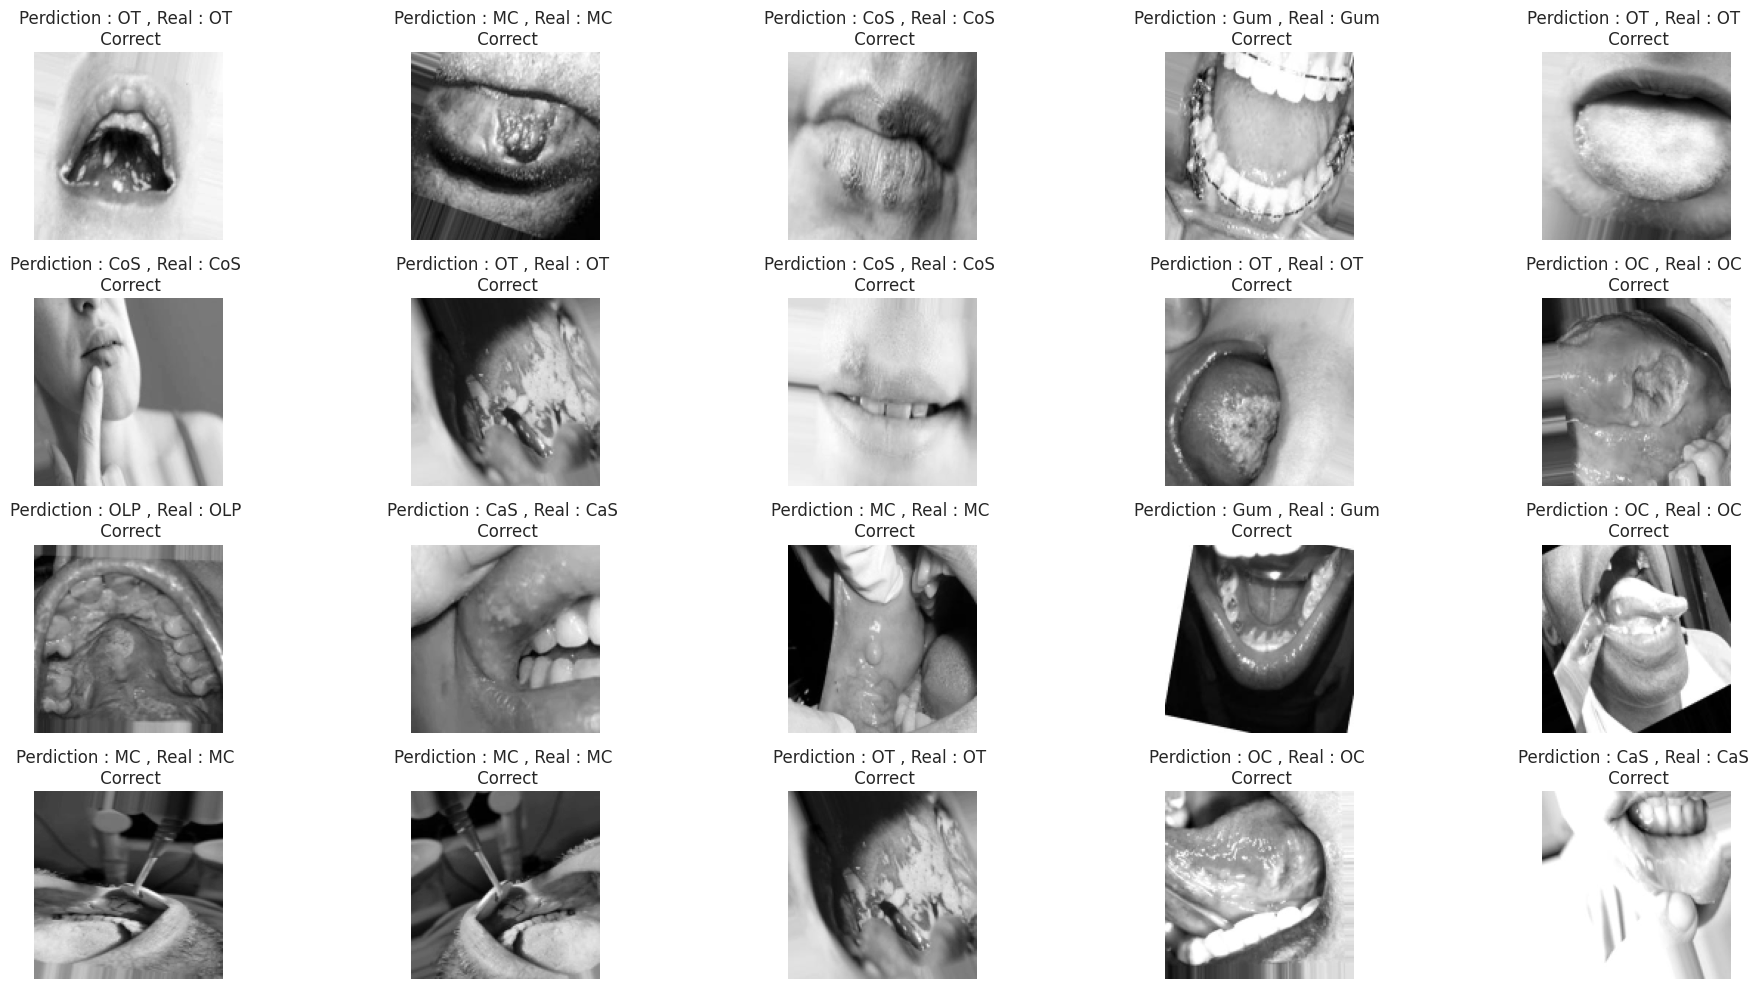

In [103]:
plt.figure(figsize=(20,10))
for i in range(20):
    img_no = np.random.randint(0, X_test.shape[0])
    pred = MOD_classes[predicitions[img_no]]
    real = MOD_classes[y_test[img_no]]
    plt.subplot(4, 5, i+1)
    plt.imshow(X_test[img_no],cmap='gray')
    plt.grid('off')
    plt.axis('off')
    
    if pred == real:   
        plt.title(f'Perdiction : {pred} , Real : {real} \n Correct')
    else:
        plt.title(f'Perdiction : {pred} , Real : {real} \n Wrong')
        
plt.tight_layout()
plt.show()

In [95]:
model.save('/kaggle/working/teeth_cnn_model.h5')